In [ ]:
import os
import json

directory = "precipitation/Precipitation Datasets"

with open('reservoir/reservoir.json', 'r') as f:
    data = json.load(f)

saData = {}

resData = {}

# Iterate through all files in the directory
for filename in os.listdir(directory):
    # Check if the current item is a file
    if os.path.isfile(os.path.join(directory, filename)):
        # Process the file here
        id = filename.split('_', maxsplit=1)[0] 
        saData[id] = {"reservoir": data[id]}
        precipitation = []
        with open(os.path.join(directory, filename), 'r') as f:
            while f.readline() != '-END HEADER-\n':
                pass
            for line in f:
                precipitation.append(line)
        saData[id]["precipitation"] = precipitation
        # saData[id].append(precipitation)

with open('mergedData.json', 'w') as f:
    json.dump(saData, f)

In [ ]:
import numpy as np
# find population around a certain radius of a location

def getClosestIndex(population, lat, lon):
    return (np.abs(population['latitude'][:] - lat).argmin(), np.abs(population['longitude'][:]-lon).argmin())

import netCDF4 as nc

data = nc.Dataset('population/gpw_v4_population_density_adjusted_rev11_2pt5_min_1_5.nc')
genDataset = data.variables['UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'][:]

from geopy import distance
import time


def findPopulationData(data, lat, lon, dist=100):
    origLatIndex, origLongIndex = getClosestIndex(data, lat, lon)

    totalPop = [0, 0, 0, 0, 0]
    checks = [0, 0, 0, 0]

    processedSize = 0

    processedData = set()
    dataToProcess = []
    dataToProcess.append((origLatIndex, origLongIndex))
    while len(dataToProcess) > 0:
        # processedSize += 1
        # if processedSize % 10 == 0:
        #     print(processedSize)
        # if processedSize % 10 == 0:
        #     break
        latIndex, lonIndex = dataToProcess.pop()
        if (latIndex, lonIndex) in processedData:
            continue
        processedData.add((latIndex, lonIndex))
        # checksTime = time.time()
        if latIndex < 0 or latIndex >= genDataset.shape[1] or lonIndex < 0 or lonIndex >= genDataset.shape[2]:
            continue
        if distance.distance((data.variables['latitude'][origLatIndex], data.variables['longitude'][origLongIndex]), (data.variables['latitude'][latIndex], data.variables['longitude'][lonIndex])).km > dist:
            continue
        # checks[0] += time.time() - checksTime
        # checksTime = time.time()
        for i in range(5):
            currItem = genDataset[i][latIndex][lonIndex]
            if currItem > 0:
                totalPop[i] += currItem
        # checks[1] += time.time() - checksTime
        # checksTime = time.time()
        for i in range(-1, 2):
            for j in range(-1, 2):
                dataToProcess.append((latIndex + i, lonIndex + j))
        # checks[2] += time.time() - checksTime
        # checksTime = time.time()
    return totalPop

import json
with open('mergedData.json', 'r') as f:
    mergedData = json.load(f)

for key in mergedData:
    print(key)
    mergedData[key]["population"] = findPopulationData(data, mergedData[key]["reservoir"][0][2], mergedData[key]["reservoir"][0][1])

with open('mergedDataPop.json', 'w') as f:
    json.dump(mergedData, f)

with open('mergedDataPop.json', 'r') as f:
    mergedDataPop = json.load(f)

months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', "11", "12"]

resData = {}

for key in mergedDataPop:
    print(key)
    print(mergedDataPop[key]["population"])
    finalData = {}
    finalDataYearly = {}
    extraData = {}
    for row in mergedDataPop[key]["reservoir"]:
        finalData[row[0]] = {
            'longitude': row[1],
            'latitude': row[2],
            'lake_area': row[3], 
            'lake_elevation': row[4],
            'lake_storage': row[5],
            'lake_evap_rate': row[6],
            'lake_evap_vol': row[7]
        }
        finalDataYearly[row[0].split('-')[0]] = {
            'longitude': row[1],
            'latitude': row[2]
        }
    discardFirstRow = True
    closestLatLon = {}
    for row in mergedDataPop[key]['precipitation']:
        if discardFirstRow:
            discardFirstRow = False
            continue
        row = row.rstrip('\n').rstrip('\\n').split(',')
        year = row[1]
        lat = float(row[2])
        lon = float(row[3])
        if year not in closestLatLon:
            closestLatLon[year] = (lat, lon, distance.distance((float(lat), float(lon)), (finalDataYearly[year]['latitude'], finalDataYearly[year]['longitude'])).km)
        else:
            dist = distance.distance((float(lat), float(lon)), (finalDataYearly[year]['latitude'], finalDataYearly[year]['longitude'])).km
            if dist < closestLatLon[year][2]:
                closestLatLon[year] = (lat, lon, dist)

    discardFirstRow = True

    extraDataPrecipitation = {'yearly': {}, 'monthly': {}}
    for row in mergedDataPop[key]['precipitation']:
        if discardFirstRow:
            discardFirstRow = False
            continue
        row = row.rstrip('\n').rstrip('\\n').split(',')
        year = row[1]
        lat, lon, _ = closestLatLon[year]

        monthStart = 4

        # jan: 2

        
        for i in range(12):
            date = year + '-' + months[i] + '-01'
            if date not in finalData:
                extraDataPrecipitation['monthly'][date] = float(row[monthStart + i])
            else:
                finalData[date]['precipitation'] = float(row[monthStart + i])

        if year not in finalDataYearly:
            extraDataPrecipitation['yearly'][year] = float(row[monthStart + 12])
        else:
            finalDataYearly[year]['precipitation'] = float(row[monthStart + 12])

    popData = {
        '2000': mergedDataPop[key]['population'][0],
        '2005': mergedDataPop[key]['population'][1],
        '2010': mergedDataPop[key]['population'][2],
        '2015': mergedDataPop[key]['population'][3],
        '2020': mergedDataPop[key]['population'][4]
    }
    extraDataPopulation = {}
    for item in popData:
        if item not in finalDataYearly:
            extraDataPopulation[item] = popData[item]
        else:
            finalDataYearly[item]['population'] = popData[item]
    
    extraData['precipitation'] = extraDataPrecipitation
    extraData['population'] = extraDataPopulation

    resData[key] = {
        'data': finalData,
        'dataYearly': finalDataYearly,
        'extraData': extraData
    }

with open('resData.json', 'w') as f:
    json.dump(resData, f)
    


In [2]:
import json
import pandas as pd

with open('resData.json', 'r') as f:
    resData = json.load(f)


# date, longitude, latitude, lake_area, lake_elevation, lake_storage, lake_evap_rate, lake_evap_vol, precipitation, population

#missing lake data: -9999
# missing precipitation data: -999


overallData = {}
missingCount = 0
for key in resData:
    currData = []
    populationData = {
        '2000': resData[key]['dataYearly']['2000']['population'],
        '2001': resData[key]['dataYearly']['2000']['population'],
        '2002': resData[key]['dataYearly']['2000']['population'],
        '2003': resData[key]['dataYearly']['2000']['population'],
        '2004': resData[key]['dataYearly']['2000']['population'],
        '2005': resData[key]['dataYearly']['2005']['population'],
        '2006': resData[key]['dataYearly']['2005']['population'],
        '2007': resData[key]['dataYearly']['2005']['population'],
        '2008': resData[key]['dataYearly']['2005']['population'],
        '2009': resData[key]['dataYearly']['2005']['population'],
        '2010': resData[key]['dataYearly']['2010']['population'],
        '2011': resData[key]['dataYearly']['2010']['population'],
        '2012': resData[key]['dataYearly']['2010']['population'],
        '2013': resData[key]['dataYearly']['2010']['population'],
        '2014': resData[key]['dataYearly']['2010']['population'],
        '2015': resData[key]['dataYearly']['2015']['population'],
        '2016': resData[key]['dataYearly']['2015']['population'],
        '2017': resData[key]['dataYearly']['2015']['population'],
        '2018': resData[key]['dataYearly']['2015']['population'],
        '2019': resData[key]['dataYearly']['2015']['population'],
        '2020': resData[key]['dataYearly']['2020']['population'],
        '2021': resData[key]['dataYearly']['2020']['population'],
        '2022': resData[key]['dataYearly']['2020']['population'],
        '2023': resData[key]['dataYearly']['2020']['population'],
    }
    for date in resData[key]['data']:
        currItem = [date, resData[key]['data'][date]['longitude'], resData[key]['data'][date]['latitude']]
        items = [resData[key]['data'][date]['lake_area'], resData[key]['data'][date]['lake_elevation'], resData[key]['data'][date]['lake_storage'], resData[key]['data'][date]['lake_evap_rate'], resData[key]['data'][date]['lake_evap_vol']]
        for item in items:
            if item == -9999:
                missingCount += 1
                currItem.append(None)
            else:
                currItem.append(item)
        if 'precipitation' not in resData[key]['data'][date]:
            missingCount += 1
            currItem.append(None)
        else:
            currItem.append(resData[key]['data'][date]['precipitation'])
        currItem.append(populationData[date.split('-')[0]])
        currData.append(currItem)
    currData.sort(key=lambda x: x[0])
    overallData[key] = currData
print(missingCount)

for key in overallData:
    for i in range(1, len(overallData[key])):
        for x in range(3, len(overallData[key][i])):
            if overallData[key][i][x] == None:
                overallData[key][i][x] = overallData[key][i-1][x]


from datetime import datetime
from dateutil.relativedelta import relativedelta

futureMonths = []

currDate = datetime.strptime('2023-07-01', '%Y-%m-%d')
extraMonths = 12*7 + 5
for i in range(extraMonths):
    currDate += relativedelta(months=1)
    futureMonths.append(currDate.strftime('%Y-%m-%d'))
    
print(futureMonths[len(futureMonths) - 1])


487
2030-12-01


/tmp/ipykernel_93575/962657976.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trueVals['decimal_year'] = pd.to_datetime(trueVals['date']).dt.year + pd.to_datetime(trueVals['date']).dt.dayofyear / 365
/tmp/ipykernel_93575/962657976.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trueVals['decimal_year'] = pd.to_datetime(trueVals['date']).dt.year + pd.to_datetime(trueVals['date']).dt.dayofyear / 365
/tmp/ipykernel_93575/962657976.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy

[(21.312019916311776, 21.036489775288324), (19.835578993011936, 18.760014426143393), (24.172318281049066, 23.699825672574885), (13.077895274521225, 12.812918307756311), (15.340048839429421, 14.739221069868814), (17.23804684898527, 16.549002984926453), (11.952713575937823, 11.915242905721547), (12.484630745641581, 12.243115099908541), (10.73161922962628, 9.784348780190005), (13.325650965624295, 12.970679755471226), (11.501751820229924, 10.670989424903981), (11.8459521865134, 10.870494217104607), (12.052195157874522, 10.942893970387862), (14.523286555835432, 14.221698436966163), (12.290587716728243, 11.220170351015646), (14.435181051069115, 13.884940505081033), (11.039584198236359, 10.823185845852421), (6.946504130806482, 5.994814773872826), (14.165179528796987, 13.516552820612738), (9.777294102677367, 8.813773068421286), (-5.431892514407078, -5.670038240548621)]


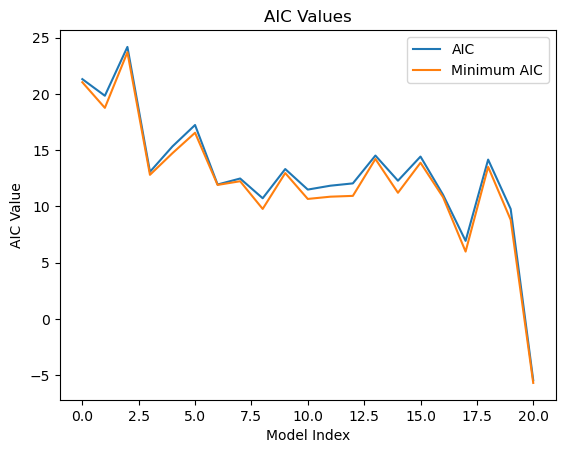

In [6]:
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

overallDataList = []

for key in overallData:
    overallDataList.append((int(key), overallData[key]))

overallDataList.sort()

nums = [8, 24, 12, 21, 18, 20, 2, 12, 21, 21, 22, 18, 24, 16, 21, 16, 20, 21, 24, 18, 9]

aicIdx = 0

aics = []
for key, _ in overallDataList:
    key = str(key)
    df = pd.DataFrame(overallData[key], columns=['date', 'longitude', 'latitude', 'lake_area', 'lake_elevation', 'lake_storage', 'lake_evap_rate', 'lake_evap_vol', 'precipitation', 'population'])
    
    df = df[['date', 'lake_storage', 'lake_evap_vol', 'lake_evap_rate', 'precipitation', 'population']]
    dfNoDate = df.drop(['date'], axis=1)
    df['predicted'] = False
    modelAics = []
    for i in range(1, 24):
        model = VAR(dfNoDate)
        model = model.fit(i)
        modelAics.append(model.aic)
    
    modelAics.sort()

    model = VAR(dfNoDate)
    

    i = nums[aicIdx]
    aicIdx += 1
    model = model.fit(i)
    aics.append((model.aic, modelAics[0]))

    res = model.forecast(dfNoDate.values[-i:], steps=extraMonths)
    dfFc = pd.DataFrame(res, columns=dfNoDate.columns)
    dfFc['date'] = futureMonths
    dfFc['predicted'] = True
    dfFc = pd.concat([df, dfFc])
    dfFc.reset_index(drop=True, inplace=True)
    col = 'lake_storage'
    trueVals = dfFc[dfFc['predicted'] == False]
    predVals = dfFc[dfFc['predicted'] == True]
    predVals = pd.concat([trueVals.iloc[[-1]], predVals])

    predVals = pd.concat([trueVals.iloc[[-1]], predVals])
    import matplotlib.pyplot as plt

    trueVals['decimal_year'] = pd.to_datetime(trueVals['date']).dt.year + pd.to_datetime(trueVals['date']).dt.dayofyear / 365
    predVals['decimal_year'] = pd.to_datetime(predVals['date']).dt.year + pd.to_datetime(predVals['date']).dt.dayofyear / 365

    plt.plot(trueVals['decimal_year'], trueVals[col], color='blue')
    plt.plot(predVals['decimal_year'], predVals[col], color='red')
    plt.xlabel('Year')
    plt.ylabel(col)
    plt.title(f'Reservoir {key} - Lake Storage - lag {i}')
    plt.savefig(f'graphs/{key}.png')
    plt.close()

print(aics)

x = range(len(aics))
aic_values = [aic[0] for aic in aics]
aic_min_values = [aic[1] for aic in aics]

plt.plot(x, aic_values, label='AIC')
plt.plot(x, aic_min_values, label='Minimum AIC')
plt.xlabel('Model Index')
plt.ylabel('AIC Value')
plt.title('AIC Values')
plt.legend()
plt.show()
